In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import nibabel as nib

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

sys.path.append("../")
from src.LSN import *

from models import dp_loss as dpl
from models import dp_utils as dpu

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Paths

In [4]:
project_dir = "../"
data_dir = "/home/nikhil/projects/brain_changes/data/ukbb/"

freesurfer_csv = f"{data_dir}imaging/freesurfer/ukb47552_followup_subset.csv"

train_csv = f"{project_dir}metadata/metadata_train.csv"
test_csv = f"{project_dir}metadata/metadata_test.csv"

freesurfer_fields = f"{project_dir}/metadata/ukbb_freesurfer_fields.txt"


## Filter followup subject using Dask dataframe (pandas will crash)

In [26]:
# import dask.dataframe as dd

# # Grab eids with ses-3 data
# freesurfer_df = pd.read_csv(freesurfer_csv,usecols=["eid","26501-3.0"])
# freesurfer_eids = freesurfer_df[~freesurfer_df["26501-3.0"].isna()]["eid"]

# # Read entire CSV using dask
# freesurfer_df = dd.read_csv(freesurfer_csv)
# followup_freesurfer_df = freesurfer_df[freesurfer_df["eid"].isin(freesurfer_eids)].compute()

# # Save filtered df
# followup_freesurfer_df.to_csv(f"{data_dir}imaging/freesurfer/ukb47552_followup_subset.csv")

## Grab phenotype fields (e.g. Thicknes, Volume, Area)

In [33]:
freesurfer_fields_df = pd.read_csv(freesurfer_fields,sep="	")
freesurfer_fields_df["phenotype"] = freesurfer_fields_df["Description"].str.split(" ",1,expand=True)[0]
freesurfer_fields_df["phenotype"] = freesurfer_fields_df["phenotype"].replace({"Mean":"Mean Thickness"})
CT_fields = freesurfer_fields_df[freesurfer_fields_df["phenotype"]=="Mean Thickness"]["Field ID"]
volume_fields = freesurfer_fields_df[freesurfer_fields_df["phenotype"]=="Volume"]["Field ID"]

print(f"number of CT fields: {len(CT_fields)}, volume fields: {len(volume_fields)}")

number of CT fields: 62, volume fields: 62


## Read DKT volumes 

In [37]:
pheno_fields = CT_fields # + volume_fields
pheno_cols_ses2 = list(pheno_fields.astype(str) + "-2.0")
pheno_cols_ses3 = list(pheno_fields.astype(str) + "-3.0")
usecols = ["eid"] + pheno_cols_ses2 + pheno_cols_ses3

print(f"reading {len(usecols)} columes")

freesurfer_df = pd.read_csv(freesurfer_csv, usecols=usecols)
freesurfer_eids = freesurfer_df["eid"].values

freesurfer_df.head()

reading 125 columes


,eid,27174-2.0,27174-3.0,27175-2.0,27175-3.0,27176-2.0,27176-3.0,27177-2.0,27177-3.0,27178-2.0,...,27293-2.0,27293-3.0,27294-2.0,27294-3.0,27295-2.0,27295-3.0,27296-2.0,27296-3.0,27297-2.0,27297-3.0
0,1000635,2.786,2.874,2.910,2.852,2.275,2.307,3.389,3.379,2.836,...,2.387,2.435,2.967,2.958,2.707,2.628,2.229,2.142,2.875,2.750
1,1008391,3.191,2.875,3.080,3.037,2.273,2.143,3.004,2.571,2.846,...,2.588,2.592,3.073,2.859,2.839,2.770,3.086,3.322,3.255,3.003
2,1010129,2.329,1.870,2.836,2.798,1.995,1.943,3.302,3.193,2.812,...,2.376,2.395,3.081,3.086,2.993,2.945,3.016,3.032,3.193,3.168
3,1010994,2.785,2.581,2.671,2.603,2.060,1.819,3.144,3.225,2.793,...,2.513,2.416,2.919,2.881,2.654,2.581,2.088,2.161,2.912,2.866
4,1013774,2.963,3.191,2.617,2.856,2.035,2.050,2.751,3.385,2.830,...,2.274,2.403,3.041,3.008,2.635,2.737,2.527,2.696,2.983,3.263


In [38]:
train_df = pd.read_csv(train_csv)
train_eids = train_df["eid"]
train_eids_avail = set(train_eids) & set(freesurfer_eids)

test_df = pd.read_csv(test_csv)
test_eids = test_df["eid"]
test_eids_avail = set(test_eids) & set(freesurfer_eids)

print(f"train samples: {len(train_eids)}, freesurfer data available: {len(train_eids_avail)}")
print(f"test samples: {len(test_eids)}, freesurfer data available: {len(test_eids_avail)}")

train samples: 2145, freesurfer data available: 1942
test samples: 1057, freesurfer data available: 978


In [47]:
class UKBB_ROI_Dataset(Dataset):
    ''' Simulation dataset
    '''
    def __init__(self, metadata_csv, data_csv, pheno_cols_ses2, pheno_cols_ses3, transform=None):
        self.metadata_csv = metadata_csv
        self.data_csv = data_csv 
        self.pheno_cols_ses2 = pheno_cols_ses2
        self.pheno_cols_ses3 = pheno_cols_ses3
        
    def __len__(self):
        n_samples = len(pd.read_csv(self.metadata_csv))
        return n_samples

    def __getitem__(self, idx):
        ukbb_metadata = pd.read_csv(self.metadata_csv)
        eid = ukbb_metadata.loc[idx,"eid"]
        age_ses2 = ukbb_metadata[ukbb_metadata["eid"]==eid]["age_at_ses2"].values[0]
        age_ses3 = ukbb_metadata[ukbb_metadata["eid"]==eid]["age_at_ses3"].values[0]
        
        usecols = ["eid"] + self.pheno_cols_ses2 + self.pheno_cols_ses3
        data_df = pd.read_csv(self.data_csv, usecols=usecols)
        input1 = data_df[data_df["eid"]==eid][self.pheno_cols_ses2].values
        input2 = data_df[data_df["eid"]==eid][self.pheno_cols_ses3].values
        
        input1 = np.expand_dims(input1,0)
        input2 = np.expand_dims(input2,0)

        output1 = age_ses2
        output2 = age_ses3
        output1 = np.expand_dims(output1,0)
        output2 = np.expand_dims(output2,0)

        return (torch.tensor(input1,dtype=torch.float32), torch.tensor(input2,dtype=torch.float32)), \
            (torch.tensor(output1,dtype=torch.float32), torch.tensor(output2,dtype=torch.float32))

In [48]:
ukbb_dataset = UKBB_ROI_Dataset(train_csv, freesurfer_csv, pheno_cols_ses2, pheno_cols_ses3, transform=None)
train_dataloader = DataLoader(ukbb_dataset, batch_size=1, shuffle=True)

In [49]:
iter(train_dataloader).next()

[[tensor([[[[3.0210, 2.4450, 3.1200, 2.8450, 1.9480, 1.8870, 3.1920, 3.3510,
             2.9070, 2.7670, 2.6990, 2.7110, 3.0920, 3.1750, 3.3170, 3.3080,
             2.3980, 2.4660, 2.2230, 2.2310, 2.7030, 2.7580, 1.9570, 1.9210,
             2.6510, 2.7150, 2.9410, 3.0840, 2.5100, 2.7000, 2.9240, 3.0870,
             2.9210, 3.0380, 2.8220, 3.1390, 2.6780, 2.6940, 1.6710, 1.6490,
             2.4060, 2.3530, 2.6490, 2.6740, 2.8820, 2.8020, 2.5960, 2.6560,
             2.9720, 2.8730, 2.7340, 2.6850, 2.9230, 2.9420, 2.4720, 2.5120,
             3.1000, 3.1350, 2.9810, 2.8420, 2.5810, 2.7270]]]]),
  tensor([[[[3.2750, 2.5590, 3.0660, 2.8080, 2.1310, 2.0050, 3.3720, 3.1520,
             2.9940, 2.8750, 2.7260, 2.8450, 3.2460, 3.2060, 3.2840, 3.1940,
             2.6960, 2.5500, 2.4170, 2.3270, 2.9900, 2.7220, 2.2170, 2.1020,
             2.7760, 2.8120, 3.1340, 3.1900, 2.5340, 2.5440, 3.1660, 3.3210,
             2.8020, 3.0140, 2.8450, 3.1170, 2.6840, 2.7720, 1.9830, 1.8710,
          

## Data-loaders

## TODO
### Data Aug:  In every epoch, the training input is 1) randomly shifted by 0, 1 or 2 voxels along every axis; 2) has a probability of 50% to be mirrored about the sagittal plane.

In [3]:
batch_size = 1

ukbb_dataset = UKBBDataset(img_dir, img_subdirs, metadata_csv)
train_dataloader = DataLoader(ukbb_dataset, batch_size=batch_size, shuffle=True)

## TwinSFCN

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = twinSFCN() # alternative toy model: LSN()

model = torch.nn.DataParallel(model)

if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'
    
model.load_state_dict(torch.load(sfcn_ckpt, map_location=torch.device('cpu')))

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

## Train model 

In [5]:
num_epochs = 10

loss_list = []
for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    print("Starting epoch " + str(epoch+1))
    for inputs, outputs in train_dataloader:
        img1 = inputs[0]
        img2 = inputs[1]
        age_at_ses2 = outputs[0]
        age_at_ses3 = outputs[1]

        # Forward
        img1 = img1.to(device)
        img2 = img2.to(device)
        age_at_ses2 = age_at_ses2.to(device)
        age_at_ses3 = age_at_ses3.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        preds = model(img1, img2)

        loss = dpl.twin_KLDivLoss(preds[0][0],preds[1][0],age_at_ses2,age_at_ses3) #criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        loss_list.append(loss.item())
    
    epoch_loss = running_loss/len(train_dataloader)
    print(f"epoch loss: {epoch_loss:3.2f}")

Starting epoch 1
(1, 160, 192, 160), (1, 160, 192, 160), (53.0, 55.0)
(1, 160, 192, 160), (1, 160, 192, 160), (70.0, 72.0)
epoch loss: 162.82
Starting epoch 2
(1, 160, 192, 160), (1, 160, 192, 160), (53.0, 55.0)
(1, 160, 192, 160), (1, 160, 192, 160), (70.0, 72.0)
epoch loss: 130.97
Starting epoch 3
(1, 160, 192, 160), (1, 160, 192, 160), (53.0, 55.0)
(1, 160, 192, 160), (1, 160, 192, 160), (70.0, 72.0)
epoch loss: 144.40
Starting epoch 4
(1, 160, 192, 160), (1, 160, 192, 160), (53.0, 55.0)
(1, 160, 192, 160), (1, 160, 192, 160), (70.0, 72.0)
epoch loss: 110.25
Starting epoch 5
(1, 160, 192, 160), (1, 160, 192, 160), (53.0, 55.0)
(1, 160, 192, 160), (1, 160, 192, 160), (70.0, 72.0)
epoch loss: 134.35
Starting epoch 6
(1, 160, 192, 160), (1, 160, 192, 160), (70.0, 72.0)
(1, 160, 192, 160), (1, 160, 192, 160), (53.0, 55.0)
epoch loss: 136.08
Starting epoch 7
(1, 160, 192, 160), (1, 160, 192, 160), (70.0, 72.0)
(1, 160, 192, 160), (1, 160, 192, 160), (53.0, 55.0)
epoch loss: 113.17
Starti

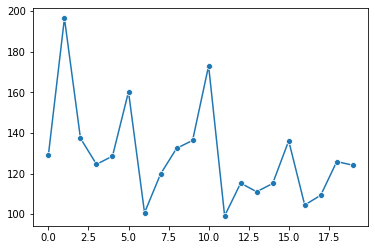

In [7]:
sns.lineplot(x=range(20),y=loss_list,marker='o')